In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

import flax.linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import pandas as pd
import seaborn as sns
from flax.training import train_state
from jax import random

from neurovae import MLPVAE, bce_loss, gaussian_kld, load_mnist, plot_digits

from plot_utils import save_comparison, save_samples

sns.set_theme(context="paper", style="darkgrid", rc={"axes.facecolor": "0.96"})
fontsize = "x-large"
params = {
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "legend.handlelength": 2,
}
plt.rcParams.update(params)

In [2]:
def run(latent_dim):

    hidden_dim = 500
    output_dim = 784
    batch_size = 64
    epochs = 100
    seed = 42

    batches, ds_test = load_mnist(
        batch_size=batch_size,
        drop_remainder=True,
        select_digits=[0, 1, 2, 3],
        as_supervised=False,
        binarized=True,
        shuffle=True,
        shuffle_seed=42,
    )

    # set values for learning rate scheduler
    total_steps = len(batches) * epochs
    init_lr = 1e-3
    alpha_lr = 1e-2

    ds_test = jax.device_put(ds_test)

    def model():
        return MLPVAE(hidden_dim, latent_dim, output_dim)

    def init_model(rng):
        rng, init_key = random.split(rng)

        initial_variables = jnp.ones((batch_size, output_dim), jnp.float32)
        params = model().init(init_key, initial_variables, rng)["params"]
        del initial_variables, init_key

        lr_schedule = optax.cosine_decay_schedule(init_lr, decay_steps=total_steps, alpha=alpha_lr)
        optimizer = optax.chain(optax.clip(1.0), optax.adamw(lr_schedule, nesterov=True))
        # optimizer = optax.adam(learning_rate)

        state = train_state.TrainState.create(
            apply_fn=model().apply,
            params=params,
            tx=optimizer,
        )
        return rng, state

    def compute_metrics(recon_x, x, mean, logvar):
        bce = bce_loss(recon_x, x).mean()  # mean over batch
        kld = gaussian_kld(mean, logvar).mean()  # mean over batch
        elbo = bce + kld
        return {"elbo": elbo, "bce": bce, "kld": kld}

    @jax.jit
    def train_step(state, batch, z_rng):

        def loss_fn(params):
            recon_x, mean, logvar = model().apply({"params": params}, batch, z_rng)
            bce = bce_loss(recon_x, batch).mean()
            kld = gaussian_kld(mean, logvar).mean()
            elbo = bce + kld
            return elbo

        grads = jax.grad(loss_fn)(state.params)
        return state.apply_gradients(grads=grads)

    @jax.jit
    def eval_f(params, images, z, z_rng):
        def eval_model(vae):
            recon_images, mean, logvar = vae(images, z_rng)

            recon_images_compare = nn.sigmoid(recon_images[:8])
            comparison = jnp.concatenate(
                [
                    images[:8].reshape(-1, 28, 28, 1),
                    recon_images_compare.reshape(-1, 28, 28, 1),
                ]
            )

            generate_images = vae.generate(z, assumption="bernoulli")
            generate_images = generate_images.reshape(-1, 28, 28, 1)
            metrics = compute_metrics(recon_images, images, mean, logvar)
            return metrics, comparison, generate_images

        return nn.apply(eval_model, model())({"params": params})

    rng = random.key(seed)
    rng, state = init_model(rng)

    rng, z_key, eval_rng = random.split(rng, 3)

    z = random.normal(z_key, (batch_size, latent_dim))  # prior
    del z_key

    epoch_metrics = []
    for epoch in range(epochs):
        for batch in batches:
            rng, key = random.split(rng)
            state = train_step(state, batch, key)

        metrics, comparison, samples = eval_f(state.params, ds_test, z, eval_rng)
        metrics["epoch"] = epoch + 1
        epoch_metrics.append(metrics)
        print(f"epoch: {epoch + 1}, ELBO: {metrics['elbo']:.4f}, BCE: {metrics['bce']:.4f}, KLD: {metrics['kld']:.4f}")

    df = pd.DataFrame(epoch_metrics)
    df.to_csv(f"./vae_data/latent_dim_{latent_dim}_vanilla_mlp_vae_bmnist.csv", index=False)
    save_comparison(comparison, f"recon_latent_dim_{latent_dim}_vanilla_mlp_vae_bmnist.pdf")
    save_samples(samples, f"samples_latent_dim_{latent_dim}_vanilla_mlp_vae_bmnist.pdf")

epoch: 1, ELBO: 180.8152, BCE: 177.2022, KLD: 3.6130
epoch: 2, ELBO: 174.1222, BCE: 170.9368, KLD: 3.1853
epoch: 3, ELBO: 165.3903, BCE: 162.2672, KLD: 3.1231
epoch: 4, ELBO: 163.4659, BCE: 160.3025, KLD: 3.1634
epoch: 5, ELBO: 162.1753, BCE: 159.0870, KLD: 3.0883
epoch: 6, ELBO: 161.3639, BCE: 158.2131, KLD: 3.1508
epoch: 7, ELBO: 160.5357, BCE: 157.3688, KLD: 3.1668
epoch: 8, ELBO: 160.0267, BCE: 156.8893, KLD: 3.1374
epoch: 9, ELBO: 159.7242, BCE: 156.5132, KLD: 3.2109
epoch: 10, ELBO: 159.3035, BCE: 156.2071, KLD: 3.0964
epoch: 11, ELBO: 159.1615, BCE: 155.9715, KLD: 3.1900
epoch: 12, ELBO: 159.0191, BCE: 155.8187, KLD: 3.2005
epoch: 13, ELBO: 158.6220, BCE: 155.4604, KLD: 3.1616
epoch: 14, ELBO: 158.3675, BCE: 155.0233, KLD: 3.3442
epoch: 15, ELBO: 158.2387, BCE: 155.0571, KLD: 3.1816
epoch: 16, ELBO: 158.0771, BCE: 154.8260, KLD: 3.2511
epoch: 17, ELBO: 157.7414, BCE: 154.4418, KLD: 3.2995
epoch: 18, ELBO: 157.3748, BCE: 154.0063, KLD: 3.3685
epoch: 19, ELBO: 157.0513, BCE: 153.6

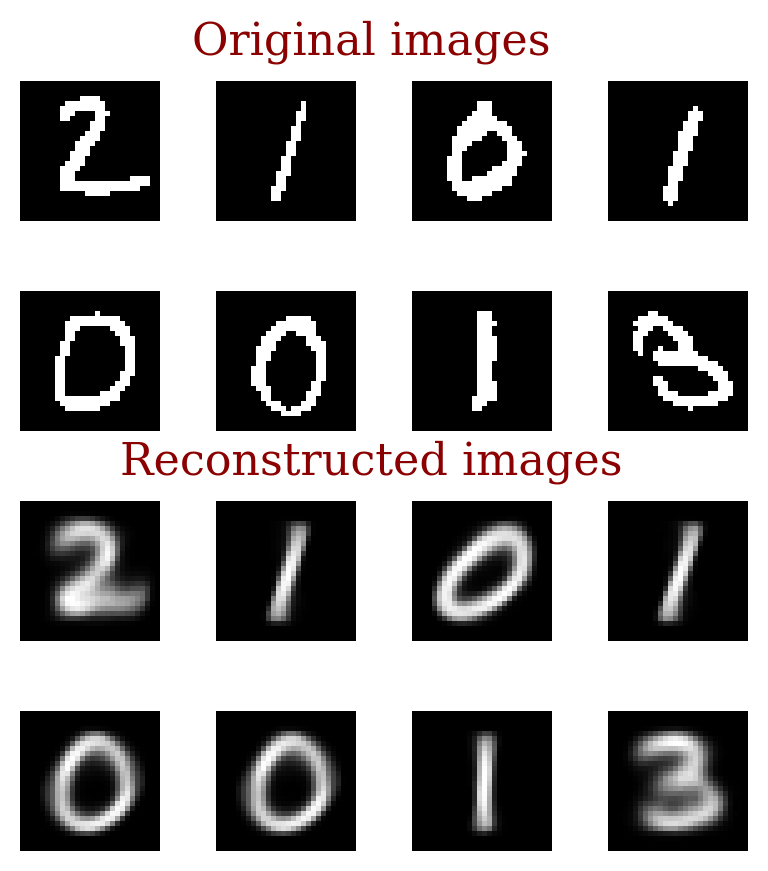

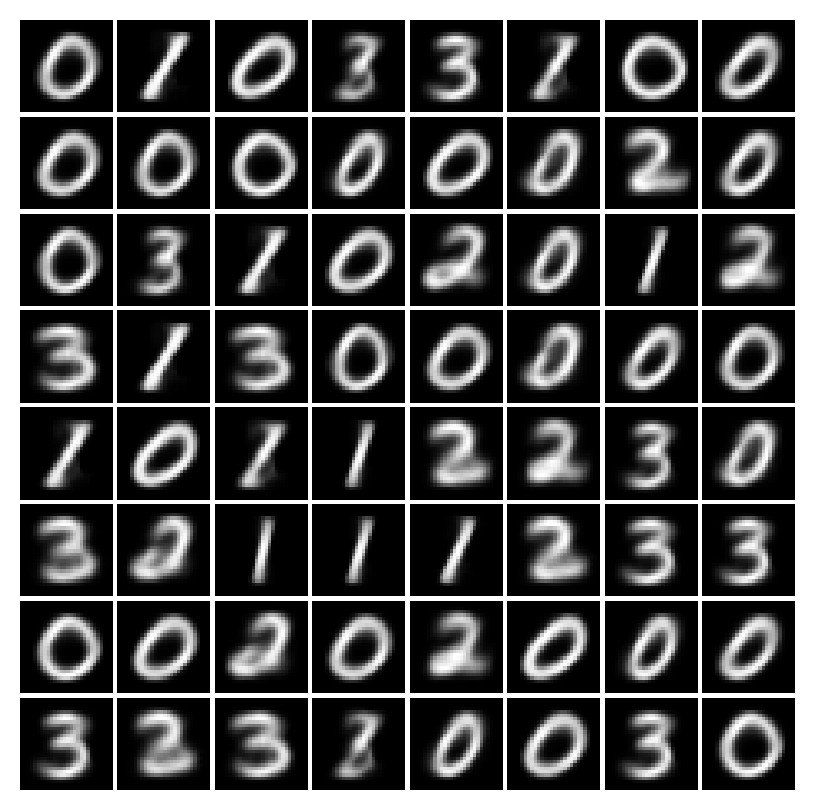

In [3]:
run(1)

epoch: 1, ELBO: 103.6044, BCE: 85.9439, KLD: 17.6605
epoch: 2, ELBO: 96.5475, BCE: 78.7078, KLD: 17.8397
epoch: 3, ELBO: 93.2971, BCE: 74.9401, KLD: 18.3570
epoch: 4, ELBO: 91.1310, BCE: 72.7587, KLD: 18.3723
epoch: 5, ELBO: 89.7667, BCE: 71.1668, KLD: 18.5999
epoch: 6, ELBO: 88.7737, BCE: 69.5992, KLD: 19.1746
epoch: 7, ELBO: 87.9695, BCE: 69.2900, KLD: 18.6795
epoch: 8, ELBO: 87.4188, BCE: 68.0215, KLD: 19.3972
epoch: 9, ELBO: 86.9323, BCE: 67.7867, KLD: 19.1456
epoch: 10, ELBO: 86.2616, BCE: 66.8655, KLD: 19.3961
epoch: 11, ELBO: 86.1133, BCE: 66.4463, KLD: 19.6670
epoch: 12, ELBO: 85.6807, BCE: 66.1530, KLD: 19.5277
epoch: 13, ELBO: 85.6077, BCE: 65.9992, KLD: 19.6085
epoch: 14, ELBO: 84.9186, BCE: 65.2716, KLD: 19.6470
epoch: 15, ELBO: 84.6415, BCE: 65.2633, KLD: 19.3782
epoch: 16, ELBO: 84.5370, BCE: 64.4685, KLD: 20.0684
epoch: 17, ELBO: 84.2005, BCE: 64.5672, KLD: 19.6333
epoch: 18, ELBO: 83.9694, BCE: 64.1902, KLD: 19.7792
epoch: 19, ELBO: 83.7236, BCE: 63.9098, KLD: 19.8139
e

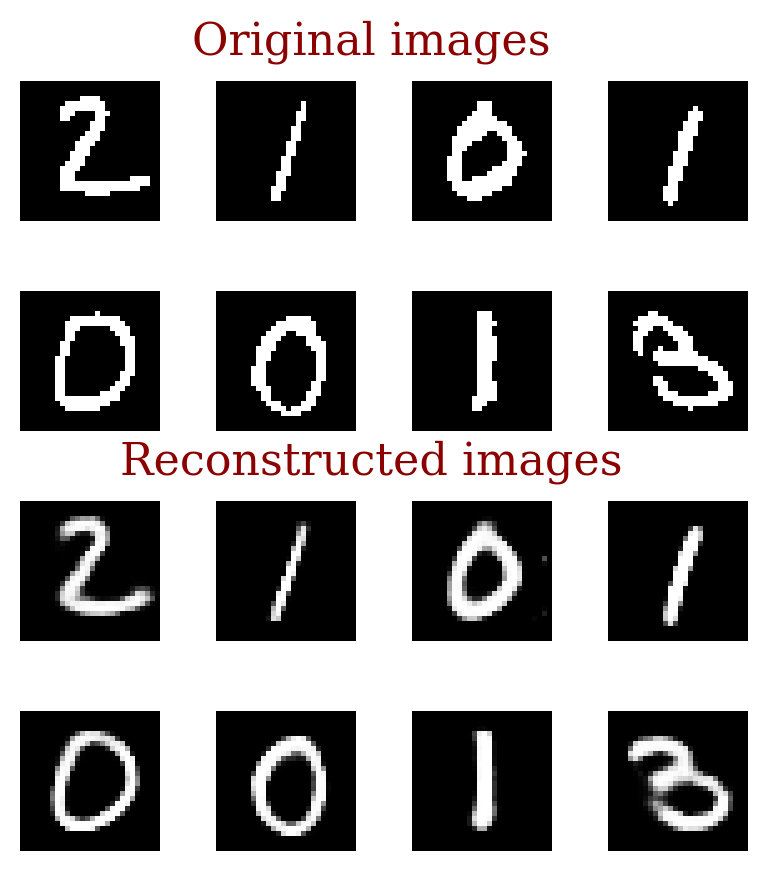

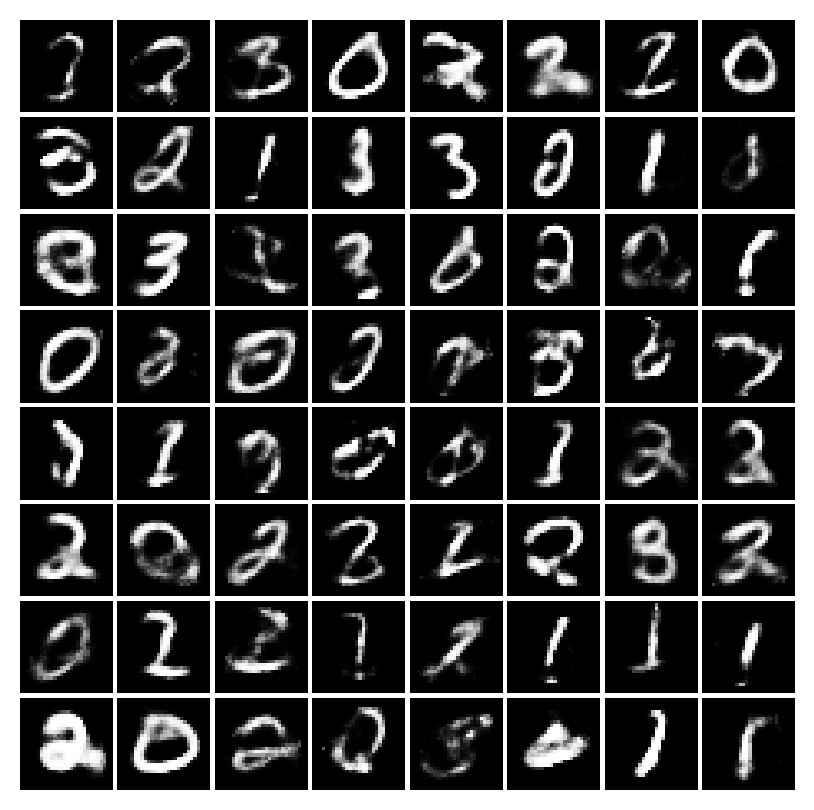

In [4]:
run(10)

epoch: 1, ELBO: 99.8409, BCE: 74.8403, KLD: 25.0006
epoch: 2, ELBO: 91.2010, BCE: 65.0152, KLD: 26.1858
epoch: 3, ELBO: 88.1235, BCE: 60.8262, KLD: 27.2972
epoch: 4, ELBO: 86.0181, BCE: 59.3578, KLD: 26.6603
epoch: 5, ELBO: 84.8085, BCE: 56.8044, KLD: 28.0041
epoch: 6, ELBO: 83.5672, BCE: 56.5030, KLD: 27.0641
epoch: 7, ELBO: 82.9745, BCE: 55.2380, KLD: 27.7366
epoch: 8, ELBO: 82.6378, BCE: 54.7431, KLD: 27.8947
epoch: 9, ELBO: 82.0551, BCE: 54.3178, KLD: 27.7373
epoch: 10, ELBO: 81.7525, BCE: 53.9949, KLD: 27.7576
epoch: 11, ELBO: 81.4087, BCE: 53.3765, KLD: 28.0323
epoch: 12, ELBO: 80.9326, BCE: 53.0053, KLD: 27.9272
epoch: 13, ELBO: 80.6141, BCE: 52.4796, KLD: 28.1345
epoch: 14, ELBO: 80.5476, BCE: 52.6045, KLD: 27.9431
epoch: 15, ELBO: 80.4406, BCE: 51.9249, KLD: 28.5157
epoch: 16, ELBO: 80.1956, BCE: 51.6922, KLD: 28.5034
epoch: 17, ELBO: 79.9334, BCE: 51.3517, KLD: 28.5818
epoch: 18, ELBO: 79.7285, BCE: 51.0609, KLD: 28.6676
epoch: 19, ELBO: 79.6889, BCE: 50.8679, KLD: 28.8211
ep

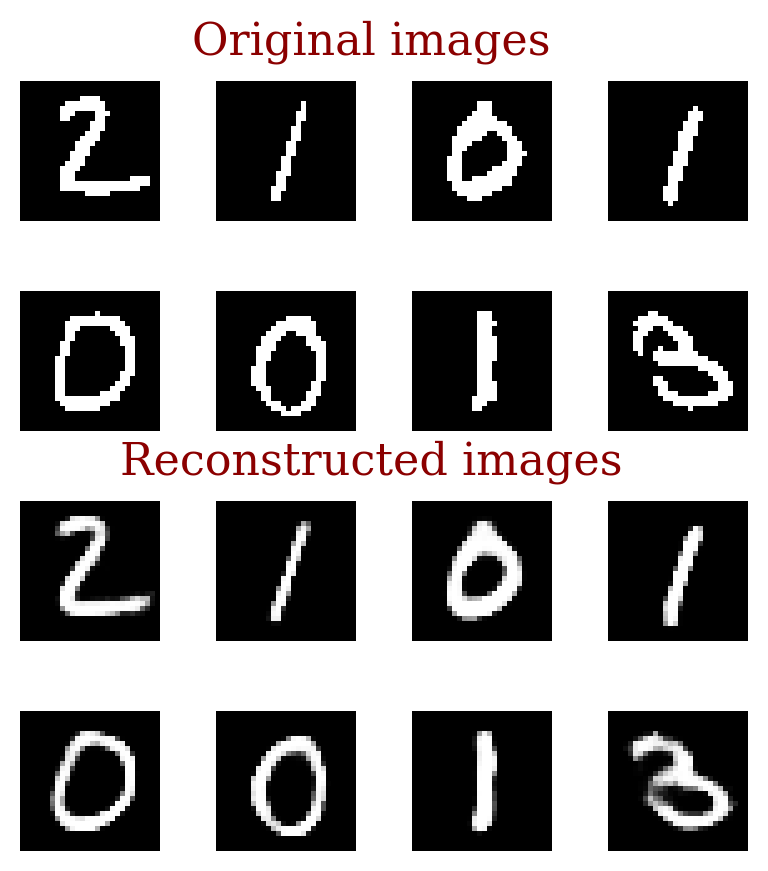

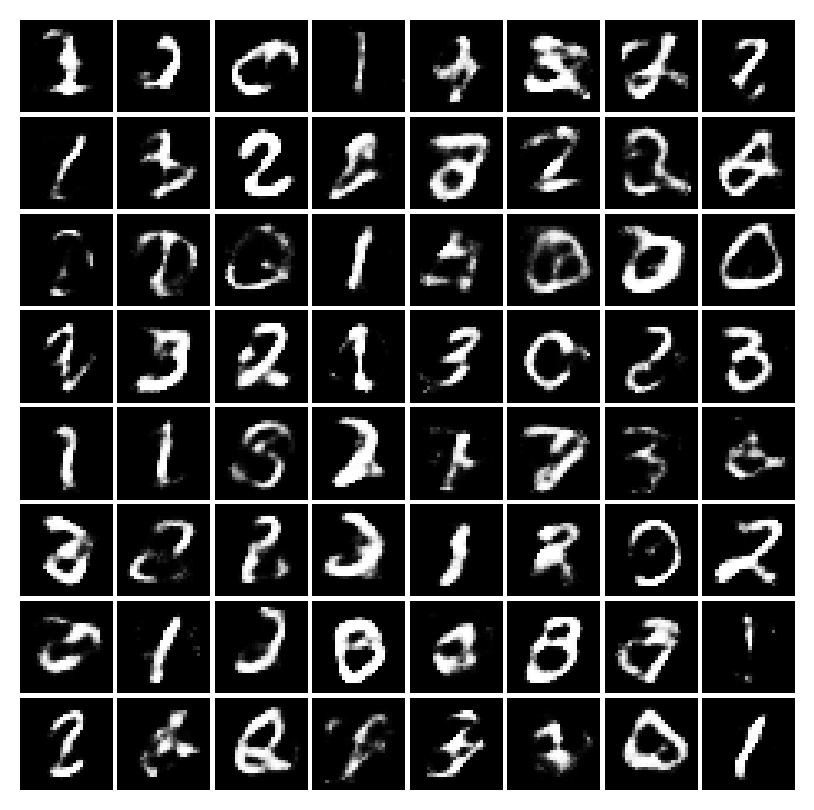

In [5]:
run(20)

epoch: 1, ELBO: 109.3672, BCE: 79.4338, KLD: 29.9334
epoch: 2, ELBO: 99.1921, BCE: 66.2666, KLD: 32.9255
epoch: 3, ELBO: 94.3290, BCE: 61.3475, KLD: 32.9816
epoch: 4, ELBO: 91.2349, BCE: 57.6562, KLD: 33.5787
epoch: 5, ELBO: 89.5045, BCE: 55.5225, KLD: 33.9821
epoch: 6, ELBO: 87.4395, BCE: 53.8186, KLD: 33.6208
epoch: 7, ELBO: 86.5565, BCE: 53.6443, KLD: 32.9122
epoch: 8, ELBO: 85.6688, BCE: 51.8284, KLD: 33.8404
epoch: 9, ELBO: 84.7746, BCE: 51.3200, KLD: 33.4546
epoch: 10, ELBO: 83.8258, BCE: 50.9716, KLD: 32.8541
epoch: 11, ELBO: 83.5421, BCE: 50.6354, KLD: 32.9067
epoch: 12, ELBO: 82.9457, BCE: 49.4901, KLD: 33.4556
epoch: 13, ELBO: 82.3617, BCE: 49.1298, KLD: 33.2319
epoch: 14, ELBO: 82.0501, BCE: 48.9200, KLD: 33.1301
epoch: 15, ELBO: 81.7616, BCE: 48.5840, KLD: 33.1776
epoch: 16, ELBO: 81.4057, BCE: 48.8829, KLD: 32.5227
epoch: 17, ELBO: 81.1660, BCE: 48.3657, KLD: 32.8003
epoch: 18, ELBO: 81.2375, BCE: 47.9670, KLD: 33.2705
epoch: 19, ELBO: 80.5775, BCE: 47.9289, KLD: 32.6487
e

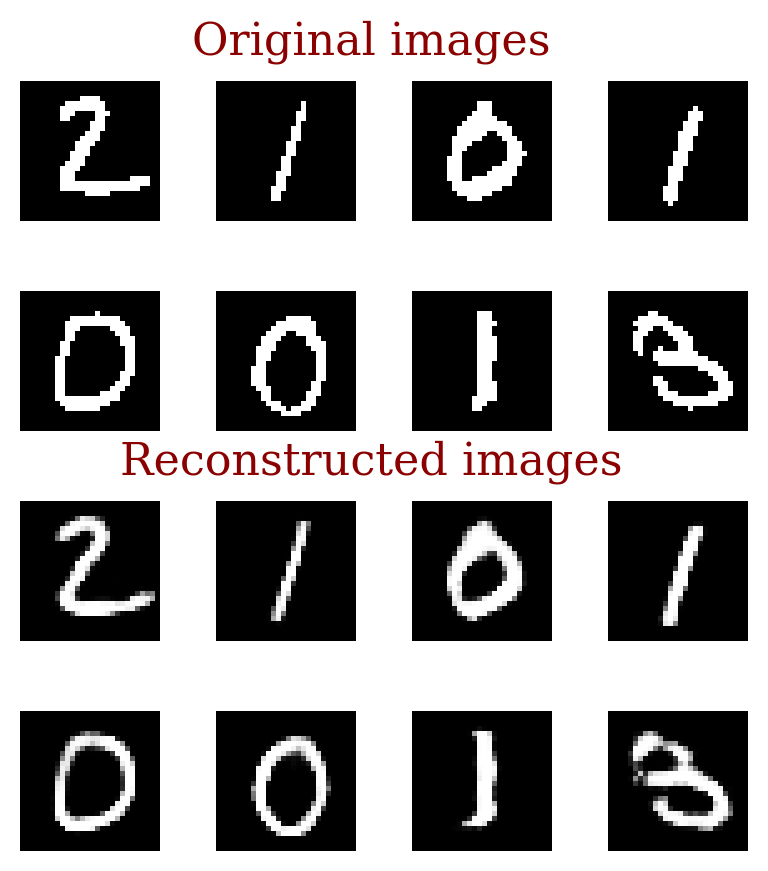

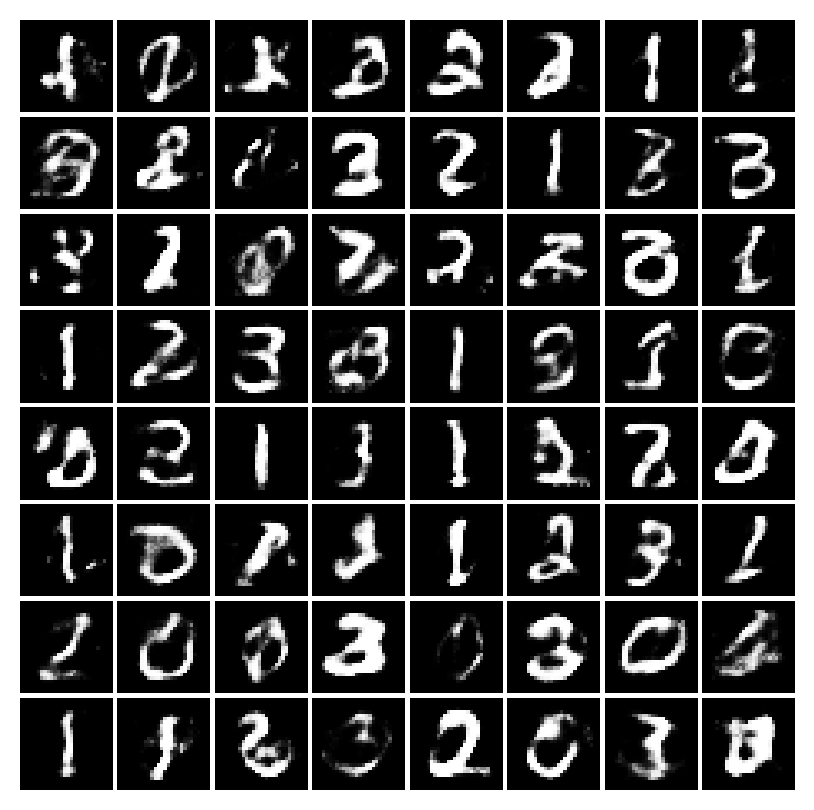

In [6]:
run(50)

epoch: 1, ELBO: 118.9631, BCE: 90.0561, KLD: 28.9070
epoch: 2, ELBO: 108.1933, BCE: 76.6820, KLD: 31.5112
epoch: 3, ELBO: 101.6608, BCE: 69.4213, KLD: 32.2394
epoch: 4, ELBO: 96.8018, BCE: 64.8686, KLD: 31.9332
epoch: 5, ELBO: 92.6985, BCE: 60.5334, KLD: 32.1651
epoch: 6, ELBO: 90.2398, BCE: 58.7544, KLD: 31.4854
epoch: 7, ELBO: 88.6555, BCE: 57.0418, KLD: 31.6137
epoch: 8, ELBO: 86.7791, BCE: 54.7749, KLD: 32.0042
epoch: 9, ELBO: 85.7100, BCE: 54.0165, KLD: 31.6935
epoch: 10, ELBO: 84.8103, BCE: 52.8105, KLD: 31.9997
epoch: 11, ELBO: 84.0334, BCE: 51.8312, KLD: 32.2022
epoch: 12, ELBO: 83.1431, BCE: 51.4030, KLD: 31.7402
epoch: 13, ELBO: 82.7849, BCE: 50.2937, KLD: 32.4912
epoch: 14, ELBO: 82.1638, BCE: 50.6146, KLD: 31.5493
epoch: 15, ELBO: 81.9836, BCE: 49.3223, KLD: 32.6613
epoch: 16, ELBO: 81.2682, BCE: 49.1105, KLD: 32.1577
epoch: 17, ELBO: 81.1790, BCE: 49.2185, KLD: 31.9605
epoch: 18, ELBO: 80.7822, BCE: 49.2262, KLD: 31.5560
epoch: 19, ELBO: 80.4104, BCE: 48.2940, KLD: 32.1163

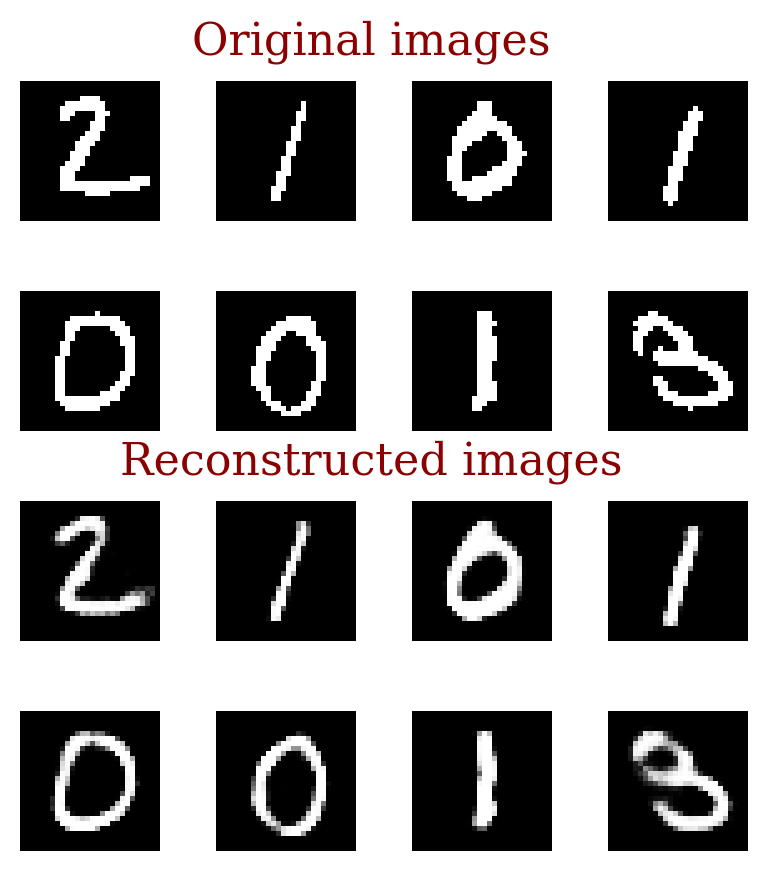

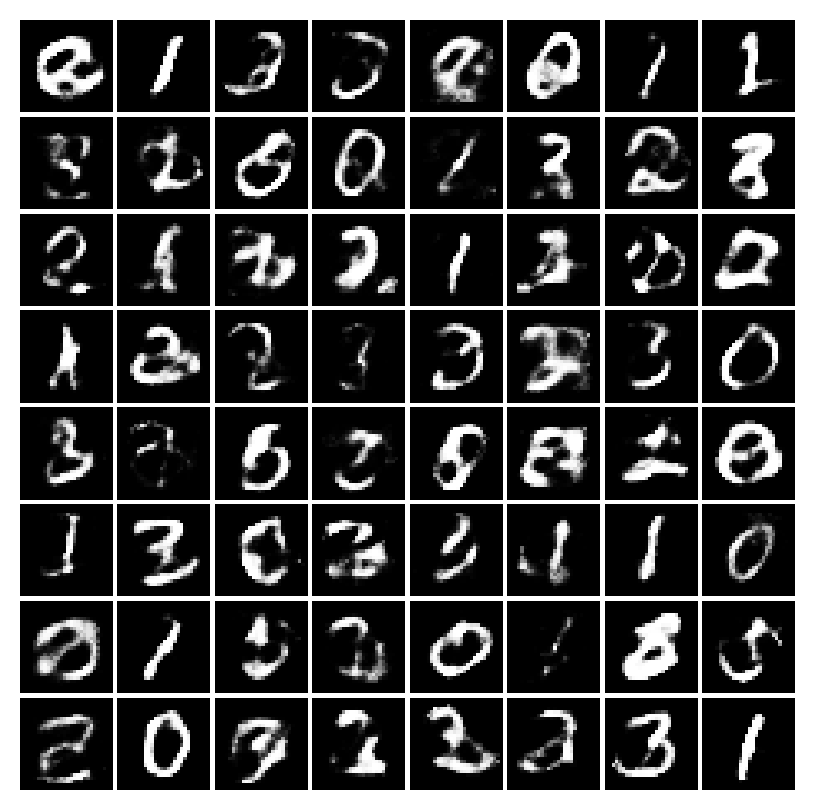

In [7]:
run(100)